# Covid-19 Mobility Deep Dive

- **Author:** Luke Fitzpatrick
- **Date:** 07/05/2021
- **Purpose:** Evaluate 2 hypotheses to explain the variation in stay-at-home behavior across geographies during the Covid-19 pandemic

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def sanitize_columns(df):
    """Sanitizes column names of dataframe
    """
    df.columns = [c.replace(' ','_').lower() for c in df.columns]
    return df


def import_trips():
    """Imports and cleans trip data
    """
    
    # Import data
    # Source: https://data.bts.gov/Research-and-Statistics/Trips-by-Distance/w96p-f2qv/data
    trips_raw = pd.read_csv('data/Trips_by_Distance.csv')
    
    # Restrict to county-level records
    trips = trips_raw.loc[trips_raw['Level'] == 'County', ['Date', 'State Postal Code', 'County FIPS', 'County Name', 'Population Staying at Home', 'Population Not Staying at Home']]
    
    # Format columns
    trips['Date'] = pd.to_datetime(trips['Date'], format='%Y/%m/%d')
    trips['County FIPS'] = trips['County FIPS'].astype(int)
    trips.loc[:, ['Population Staying at Home', 'Population Not Staying at Home']] = trips.loc[:, ['Population Staying at Home', 'Population Not Staying at Home']].fillna(0)
    
    # Create total population field
    trips['population_total'] = trips['Population Staying at Home'] + trips['Population Not Staying at Home']
    trips = trips.loc[trips['population_total'] > 0]
    
    # Rename columns
    trips.rename(columns={'State Postal Code': 'state'}, inplace=True)
    trips = sanitize_columns(trips)
    
    assert(len(trips[['date', 'county_fips']].drop_duplicates()) == len(trips))
    print(f'Imported trip data ({len(trips)} records).')
    
    return trips

def import_cases():
    """Imports and cleans COVID-19 case data
    """
    
    # Import data
    cases_raw = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us-counties.csv')
    
    # Remove records with negative case counts (data errors)
    cases_tmp = cases_raw.loc[cases_raw['cases'] >= 0, ['date', 'geoid', 'county', 'state', 'cases']]
    
    # Format olumns
    cases_tmp['date'] = pd.to_datetime(cases_tmp['date'], format='%Y-%m-%d')
    cases_tmp['county_fips'] = cases_tmp['geoid'].str.split('-').str[1].astype(int)
    
    # Create rolling count variable
    counts = cases_tmp.groupby(['county_fips', 'date'])[['cases']].sum()
    rolling_counts = counts.groupby(['county_fips', 'date'])['cases'].rolling(14, min_periods=1).sum()
    rolling_counts.name = 'cases_14d'
    cases = pd.merge(counts, rolling_counts, left_index=True, right_index=True)
    
    # Rename columns
    cases = sanitize_columns(cases)
    
    print(f'Imported COVID-19 case data ({len(cases)} records).')
    
    return cases

def import_rural_urban():
    """Imports and cleans county rural/urban indicator data
    """
    
    # Import data
    # Source: https://www.ers.usda.gov/webdocs/DataFiles/53251/ruralurbancodes2013.xls?v=8117.6
    rural_urban_raw = pd.read_excel('data/ruralurbancodes2013.xls')

    # Create aggregated description fields
    rural_urban = rural_urban_raw.copy()
    rural_urban['county_type2'] = rural_urban['Description'].str.split(' - ').str[0]
    rural_urban['county_type3'] = np.where(rural_urban['Description'].str.startswith('Metro - Counties in metro areas of 1 million population or more'),
                                      'Metro (Large 1mil+)',
                                      np.where(rural_urban['Description'].str.startswith('Metro'),
                                              'Metro (Small <1mil)', 'Nonmetro'))
    
    # Rename columns
    rural_urban.rename(columns={'FIPS': 'county_fips', 
                                'Description': 'county_desc'}, inplace=True)
    rural_urban = sanitize_columns(rural_urban)
    
    assert(rural_urban['county_fips'].nunique() == len(rural_urban))
    print(f'Imported rural/urban indicator data ({len(rural_urban)} records).')
    
    return rural_urban

def import_income():
    """Imports and cleans county income data
    """
    
    # Import data
    income_raw = pd.read_excel('https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-state-and-county/est19all.xls', skiprows=range(0,3))
    
    # Create county FIPS variable
    income_raw['county_fips'] = income_raw['State FIPS Code'] * 1000 + income_raw['County FIPS Code']
    income = income_raw.loc[:, ['county_fips', 'Name', 'Postal Code', 'Median Household Income']]
    
    # Correct errors
    income.loc[income['county_fips'] == 15005, 'Median Household Income'] = 69375
    income['Median Household Income'] = income['Median Household Income'].astype(float)
    
    # Rename columns
    income.rename(columns={'Postal Code': 'state', 
                           'Name': 'county_name'}, inplace=True)
    income = sanitize_columns(income)
    
    assert(income['county_fips'].nunique() == len(income))
    print(f'Imported county income data ({len(income)} records).')
    
    return income

def weighted_qcut(values, weights, q, **kwargs):
    'Return weighted quantile cuts from a given series, values.'
    if type(q) == int:
        quantiles = np.linspace(0, 1, q + 1)
    else:
        quantiles = q
    order = weights.iloc[values.argsort()].cumsum()
    bins = pd.cut(order / order.iloc[-1], quantiles, **kwargs)
    return bins.sort_index()

def attach_income_quantiles(df, pop_df, n_quantiles):
    """Attaches income quantiles to df, with population weights based on pop_df
    """
    
    # Attach population data
    df.drop(columns=['population_2010'], inplace=True, errors='ignore')
    df = df.merge(pop_df[['county_fips', 'population_2010']], on='county_fips')
    
    # Format columns
    df['population_2010'] = df['population_2010'].astype(int)
    
    # Create quantile columns
    df['income_quantile_count'] = pd.qcut(df['median_household_income'], n_quantiles, labels=False) + 1
    df['income_quantile_pop'] = weighted_qcut(df['median_household_income'], df['population_2010'], n_quantiles, labels=False) + 1
    
    return df

def weekly_summary(df, pop_vars):
    """Resamples dataframe at a weekly level
    """

    df_w = trips.groupby('county_fips').resample('W-Sun', on='date').mean()
    df_w = df_w[pop_vars].reset_index()
    
    # Add week number
    df_w['week'] = df_w['date'].dt.isocalendar().week
    df_w['week52'] = np.minimum(df_w['week'], 52)
    
    return df_w

## 2. Data import and transformations
Exploratory data analysis in separate notebook, but the results inform the cleaning steps here

In [3]:
trips = import_trips()

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Imported trip data (2802325 records).


In [4]:
cases = import_cases()

Imported COVID-19 case data (1462310 records).


In [5]:
rural_urban = import_rural_urban()

Imported rural/urban indicator data (3234 records).


In [6]:
income = import_income()
income = attach_income_quantiles(income, rural_urban.loc[:, ['county_fips', 'population_2010']], 5)

Imported county income data (3194 records).


In [7]:
# Define population variables
pop_vars = ['population_staying_at_home',
               'population_not_staying_at_home',
               'population_total']

# Weekly trip summary
trips_w = weekly_summary(trips, pop_vars)

# Attach county-level fields
trips_w.drop(columns=['county_desc', 'county_type2', 'county_type3', 'median_household_income', 'income_quantile_count', 'income_quantile_pop'], inplace=False, errors='ignore')
trips_w = trips_w.merge(rural_urban[['county_fips', 'county_desc', 'county_type2', 'county_type3']], on='county_fips', how='left')\
                .merge(income[['county_fips', 'median_household_income', 'income_quantile_count', 'income_quantile_pop']], on='county_fips', how='left')

# Impute null values
trips_w[['county_desc', 'county_type2', 'county_type3']] = trips_w[['county_desc', 'county_type2', 'county_type3']].fillna('Unknown')


## 3. Data summaries

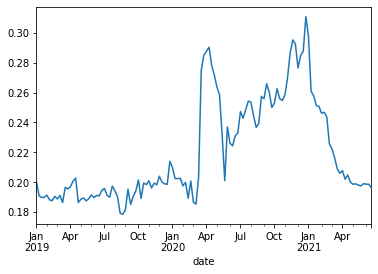

In [8]:
# Stay-at-home rates over time
s = trips_w.groupby('date')[['population_total', 'population_staying_at_home']].sum()
s['stay_home_rate'] = s['population_staying_at_home'] / s['population_total']
s['stay_home_rate'].plot()

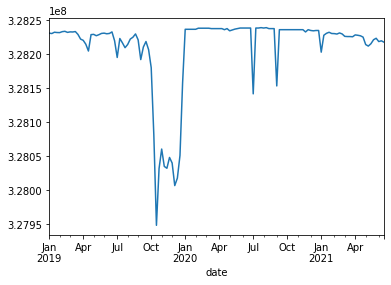

In [9]:
# Total population over time
s['population_total'].plot()

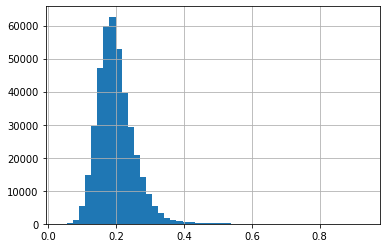

In [10]:
# Stay-at-home rate distribution by county/week
trips_w['stay_home_rate'] = trips_w['population_staying_at_home'] / trips_w['population_total']
trips_w['stay_home_rate'].hist(bins=50)

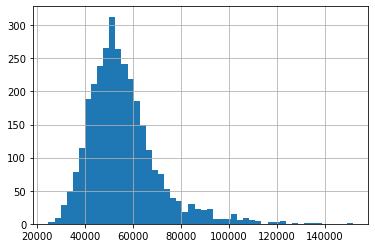

In [11]:
# Median household income distribution by county
income['median_household_income'].hist(bins=50)

In [12]:
# Income quantiles
income.groupby('income_quantile_pop')['median_household_income'].agg(['min', 'mean', 'max']).round(-2).astype(int)

,min,mean,max
income_quantile_pop,,,
1,24700,45000,53000
2,53000,56900,61400
3,61400,64800,69400
4,69400,74400,82300
5,82400,95600,151800


In [13]:
# Population by income quantiles
income.groupby('income_quantile_pop')['population_2010'].sum()

income_quantile_pop
1    61667641
2    61599200
3    58833565
4    64728048
5    61889817
Name: population_2010, dtype: int32

In [14]:
# Urban/rural category
rural_urban.groupby(['county_type3', 'county_type2', 'county_desc'])['population_2010'].agg(['sum', 'nunique'])

sum  \
county_type3        county_type2    county_desc                                                     
Metro (Large 1mil+) Metro           Metro - Counties in metro areas of 1 million po...  170874087   
Metro (Small <1mil) Metro           Metro - Counties in metro areas of 250,000 to 1...   66299877   
                                    Metro - Counties in metro areas of fewer than 2...   28845692   
Nonmetro            Nonmetro        Nonmetro - Completely rural or less than 2,500 ...    2157448   
                                    Nonmetro - Completely rural or less than 2,500 ...    2615681   
                                    Nonmetro - Urban population of 2,500 to 19,999,...   14837258   
                                    Nonmetro - Urban population of 2,500 to 19,999,...    8265281   
                                    Nonmetro - Urban population of 20,000 or more, ...   13633186   
                                    Nonmetro - Urban population of 20,000 or more, ...    5317982   
                    Not Applicable  Not Applicable                                              0   

                                                                                        nunique  
county_type3        county_type2    county_desc                                                  
Metro (Large 1mil+) Metro           Metro - Counties in metro areas of 1 million po...      472  
Metro (Small <1mil) Metro           Metro - Counties in metro areas of 250,000 to 1...      394  
                                    Metro - Counties in metro areas of fewer than 2...      367  
Nonmetro            Nonmetro        Nonmetro - Completely rural or less than 2,500 ...      219  
                                    Nonmetro - Completely rural or less than 2,500 ...      420  
                                    Nonmetro - Urban population of 2,500 to 19,999,...      594  
                                    Nonmetro - Urban population of 2,500 to 19,999,...      433  
                                    Nonmetro - Urban population of 20,000 or more, ...      217  
                                    Nonmetro - Urban population of 20,000 or more, ...       98  
                    Not Applicable  Not Applicable                                            1

In [15]:
# Population by urban/rural category
s = rural_urban.groupby('county_type3')[['population_2010']].sum()
s.div(s.sum())

,population_2010
county_type3,
Metro (Large 1mil+),0.546191
Metro (Small <1mil),0.304129
Nonmetro,0.149680


## 4. Hypothesis testing
### Hypothesis 1: Regions with high recent infection rates have higher stay-at-home rates

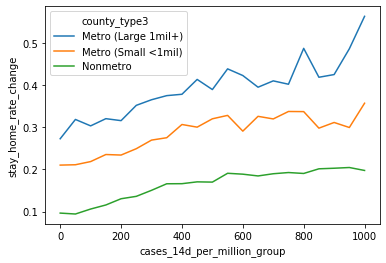

In [16]:
def stay_home_summary(df, group_vars):
    """Returns summary of pre/post stay-at-home rates
    """
    summary = df.groupby(group_vars)[['population_total', 'population_staying_at_home', 'population_staying_at_home_pre_scaled']].sum()
    summary['stay_home_rate'] = summary['population_staying_at_home'] / summary['population_total']
    summary['stay_home_rate_pre'] = summary['population_staying_at_home_pre_scaled'] / summary['population_total']
    summary['stay_home_rate_change'] = summary['stay_home_rate'] / summary['stay_home_rate_pre'] - 1
    return summary

# Merge post-COVID and pre-COVID data sets
trips_w_post = trips_w.loc[trips_w['date'] >= dt.datetime(2020, 3, 1, 0, 0, 0)]
trips_w_pre = trips_w.loc[trips_w['date'].dt.year == 2019, ['county_fips', 'week52'] + pop_vars]
trips_w_pre.rename(columns={c: c + '_pre' for c in pop_vars}, inplace=True)
trips_w_comp = pd.merge(trips_w_post, trips_w_pre, on=['county_fips', 'week52'], how='left')

# Plot parameters
bin_width = 50
min_cases = 0
max_cases = 1000

# Merge trailing 14-day case counts
df = trips_w_comp.merge(cases[['cases_14d']], left_on=['county_fips', 'date'], right_index=True)
df['cases_14d_per_million'] = df['cases_14d'] / df['population_total'] * 1e6
df['cases_14d_per_million_group'] = ((df['cases_14d_per_million'] / bin_width).apply(np.floor) * bin_width).clip(min_cases, max_cases)
df['population_staying_at_home_pre_scaled'] = df['population_staying_at_home_pre'] / df['population_total_pre'] * df['population_total']

# Summarize by county type
summary_type_cases = stay_home_summary(df.loc[df['county_type3'] != 'Unknown'], ['county_type3', 'cases_14d_per_million_group'])

# Plot
sns.lineplot(data=summary_type_cases.reset_index(),
             x='cases_14d_per_million_group', 
             y='stay_home_rate_change',
             hue='county_type3')

In [17]:
# CSV for slide
summary_type_cases.reset_index().to_csv('summary_type_cases.csv', index=False)

In [18]:
# Overall summary by county type
summary_type = stay_home_summary(df.loc[df['county_type3'] != 'Unknown'], 'county_type3')
summary_type

,population_total,population_staying_at_home,population_staying_at_home_pre_scaled,stay_home_rate,stay_home_rate_pre,stay_home_rate_change
county_type3,,,,,,
Metro (Large 1mil+),1.171831e+10,2.972006e+09,2.250757e+09,0.253621,0.192072,0.320447
Metro (Small <1mil),6.595204e+09,1.541598e+09,1.250434e+09,0.233745,0.189597,0.232851
Nonmetro,2.942520e+09,6.082847e+08,5.456859e+08,0.206722,0.185448,0.114716


### Hypothesis 2: Permanent shift toward staying at home in wealthier regions

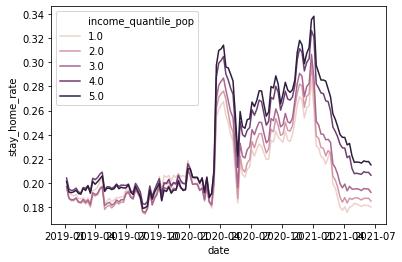

In [19]:
# Time-series by income quantile
summary_income = trips_w.groupby(['income_quantile_pop', 'date'])[['population_total', 'population_staying_at_home']].sum()
summary_income['stay_home_rate'] = summary_income['population_staying_at_home'] / summary_income['population_total']
sns.lineplot(data=summary_income.reset_index(),
            x='date',
            y='stay_home_rate',
            hue='income_quantile_pop',
            legend='full')

In [20]:
# CSV for slide
summary_income.reset_index().to_csv('summary_income.csv', index=False)

## 5. Data export for Tableau map

In [21]:
cmap = trips.loc[trips['date'] == trips['date'].max()]
cmap['county_fips'] = cmap['county_fips'].astype(str).apply(lambda x: x.zfill(5))
cmap['stay_home_rate'] = cmap['population_staying_at_home'] / cmap['population_total']
cmap.loc[:, ['county_fips', 'stay_home_rate']].to_csv('cmap.csv', index=False)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
